In [1]:
import numpy as np
from copy import deepcopy
from pprint import pprint
import sys, os, time
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.pyplot import cm


sys.path.append('/mnt/e/dhh-soltesz-lab/zfish-proj/src-parallel/operation-figgeritout/comp-modeling/utils')

from futils import extract_weights, get_ei, gaussian_mixture_modeling, jthreshold
from modeling_analysis_utils import extract_top_J, load_simulation_parameters, plot_example_traces
from rnn_modeling_utils import solve_stochastic_euler
from graph_utils import leiden_clustering

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

%load_ext autoreload
%autoreload 2

## ei analysis, modularity analysis, motif analysis

In [2]:
FISH_ID = 5
version = 1

def acquire_info(date, state, idx):
    J_filepath           = '/mnt/f/dhh-soltesz-lab/zfish-modeling-outputs/f%i/%s/v%i/training-%s' % (FISH_ID, state, version, date)
    parameters_filepath  = '/mnt/f/dhh-soltesz-lab/zfish-modeling-outputs/f%i/%s/v%i/additional-info-%s.npz' % (FISH_ID, state, version, date)

    f = np.load(J_filepath + '/full-%s-%i.npz' % (state,idx), allow_pickle=True)
    J = f['J']
    N = J.shape[0]
    f.close()

    simulation_kwargs = load_simulation_parameters(parameters_filepath)
    simulation_kwargs['J'] = J

    Ytruth = simulation_kwargs['Ytruth']
    currents    = solve_stochastic_euler(**simulation_kwargs)
    activations = np.tanh(currents)
    Ymodel      = np.matmul(J, activations)
    


    simulation_kwargs['H'] = np.zeros_like(simulation_kwargs['H'], dtype='float32')
    currents_naked    = solve_stochastic_euler(**simulation_kwargs)
    activations_naked = np.tanh(currents_naked)
    Ymodel_naked     = np.matmul(J, activations_naked)

    
    return {'J': J, 'Ytruth': Ytruth, 'Ymodel': Ymodel, 'Ymodel naked': Ymodel_naked, 'currents': currents, 'currents naked': currents_naked}

# 2 381 270
# 3 646 285
# 5 362 83
baseline_data = acquire_info('3152020', 'baseline',362)
presz_data    = acquire_info('3152020', 'presz', 83)

Jbaseline = baseline_data['J']
Jpresz    = presz_data['J']

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


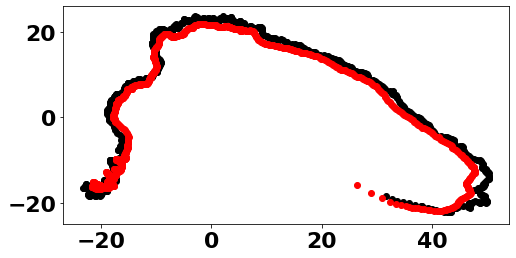

In [4]:
from futils import pca_analysis

#def pca_analysis(X, n_components=2, kernel='rbf',pca=None):

pca_baseline, truth_baseline_transformed = pca_analysis(baseline_data['Ytruth'], kernel='linear', pca=None)
_, model_baseline_transformed = pca_analysis(baseline_data['Ymodel'], kernel='linear', pca=pca_baseline)

plt.figure(figsize=(8,4))
plt.scatter(*truth_baseline_transformed, color='k')
plt.scatter(*model_baseline_transformed, color='r')
plt.show()

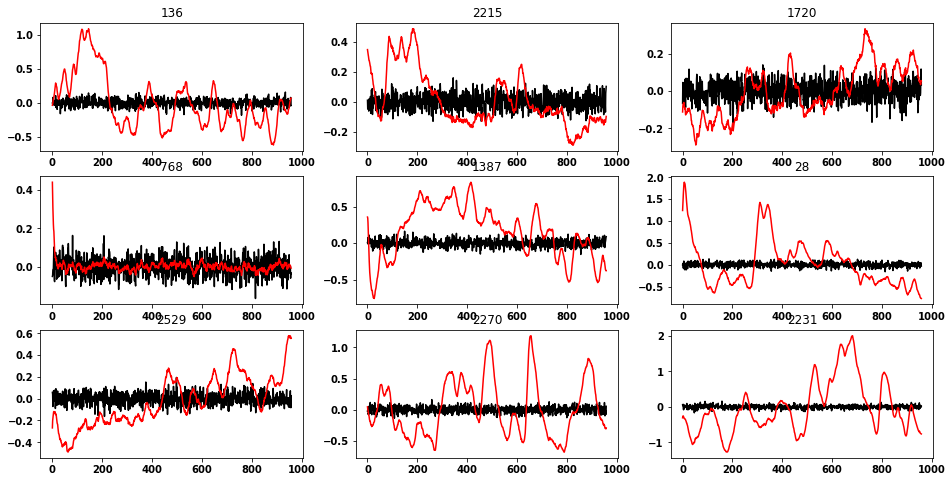

In [17]:
# plt.figure(figsize=(12,8))
# plt.imshow(currents, cmap='inferno', aspect='auto')
# plt.colorbar()
# plt.show()

# plt.figure(figsize=(12,8))
# plt.imshow(activations, cmap='inferno', aspect='auto', vmin=-1., vmax=1.)
# plt.colorbar()
# plt.show()


# plt.figure(figsize=(12,8))
# plt.imshow(currents_naked, cmap='inferno', aspect='auto')
# plt.colorbar()
# plt.show()

# plt.figure(figsize=(12,8))
# plt.imshow(activations_naked, cmap='inferno', aspect='auto', vmin=-1., vmax=1.)
# plt.colorbar()
# plt.show()

state = 'baseline'
date  = '3152020'
data = baseline_data
parameters_filepath  = '/mnt/f/dhh-soltesz-lab/zfish-modeling-outputs/f%i/%s/v%i/additional-info-%s.npz' % (FISH_ID, state, version, date)
simulation_kwargs = load_simulation_parameters(parameters_filepath)
N = Jbaseline.shape[0]

fig, ax = plt.subplots(3,3,figsize=(16,8))
for i in range(9):
    x,y = int(i/3), int(i%3)
    ridx = np.random.randint(0, N)
    ax[x,y].plot(simulation_kwargs['H'][ridx,:], color='k')
    ax[x,y].plot(data['currents'][ridx,:], color='r')
    ax[x,y].set_title(ridx)
    #ax[x,y].plot(data['currents naked'][ridx,:], color='r', linestyle='--')


1439


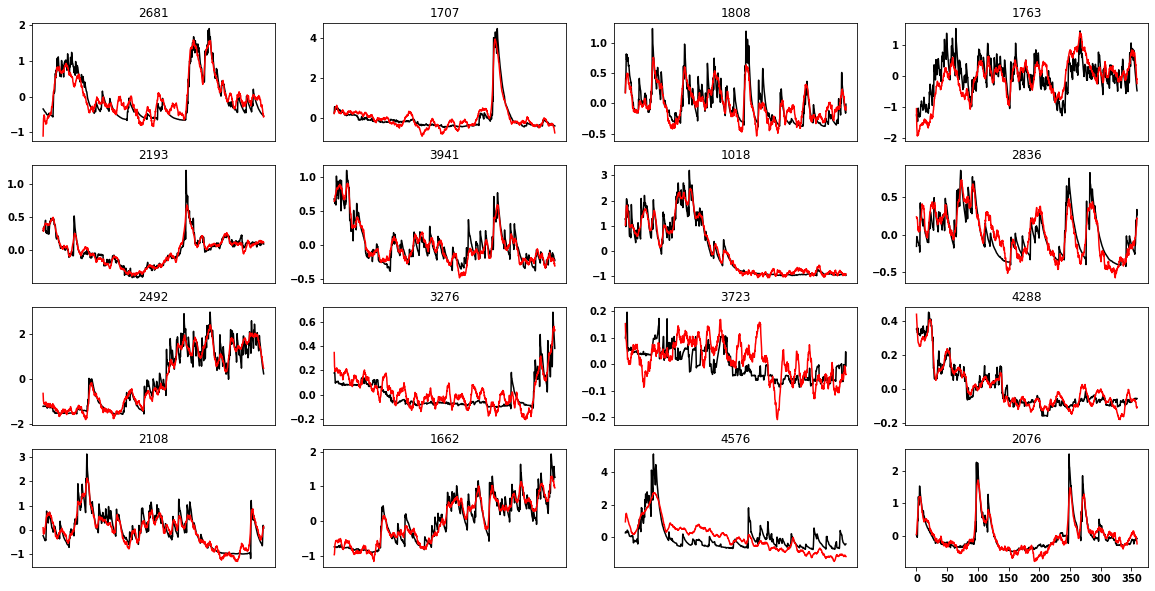

In [7]:
def plot_corrs(truth, model):
    truth_corr, model_corr = np.corrcoef(truth), np.corrcoef(model)
    plt.figure()
    plt.imshow(truth_corr, cmap='inferno', vmin=-1., vmax=1.)
    plt.show()
    
    plt.figure()
    plt.imshow(model_corr, cmap='inferno', vmin=-1., vmax=1.)
    plt.show()
    
    corr_diff = np.abs(truth_corr-model_corr)
    plt.figure(figsize=(12,6))
    plt.hist(extract_weights(corr_diff, directed=False,nonzero=True), bins=30, density=True, cumulative=True,rwidth=0.65,color='r')
    plt.show()
    
state = 'presz'
date  = '3152020'
data  = presz_data
parameters_filepath  = '/mnt/f/dhh-soltesz-lab/zfish-modeling-outputs/f%i/%s/v%i/additional-info-%s.npz' % (FISH_ID, state, version, date)
simulation_kwargs = load_simulation_parameters(parameters_filepath)
Ytruth, Ymodel, Ymodel_naked = data['Ytruth'], data['Ymodel'], data['Ymodel naked'] 
#plot_corrs(Ytruth, Ymodel)
idxs = plot_example_traces(Ytruth.shape[0], simulation_kwargs['times'], Ytruth, Ymodel, idxs=None)

#plot_corrs(Ytruth, Ymodel_naked)
#idxs = plot_example_traces(Ytruth.shape[0], simulation_kwargs['times'], Ytruth, Ymodel_naked, idxs=idxs)


In [8]:
Jpos = np.clip(J, 0., np.max(J))
Jneg = np.clip(-1*J, 0., np.max(-1*J))

plt.figure(figsize=(12,8))
plt.imshow(Jpos, cmap='inferno', vmin=0, vmax=np.percentile(Jp, 99.))
plt.title('exc')
plt.colorbar()
plt.show()

plt.figure(figsize=(12,8))
plt.imshow(Jneg, cmap='inferno', vmin=0, vmax=np.percentile(Jp, 99.))
plt.title('inh')
plt.colorbar()
plt.show()


Jpos_lst = Jlst[Jlst>0]
Jneg_lst = -1*Jlst[Jlst<0]

fig, ax = plt.subplots(figsize=(12,8))
ax.set_yscale('log')
Jphist, Jbins = np.histogram(Jpos_lst, bins=np.linspace(0,15,50), density=True)
plt.plot(Jbins[1:], Jphist, color='k')
plt.scatter(Jbins[1:], Jphist, color='k')

Jnhist, Jbins = np.histogram(Jneg_lst, bins=np.linspace(0,15,50), density=True)
plt.plot(Jbins[1:], Jnhist, color='r')
plt.scatter(Jbins[1:], Jnhist, color='r')
plt.show()


# (1) exc vs inh baseline
# (2) exc vs inh presz
# (3) baseline vs presz

NameError: name 'J' is not defined

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


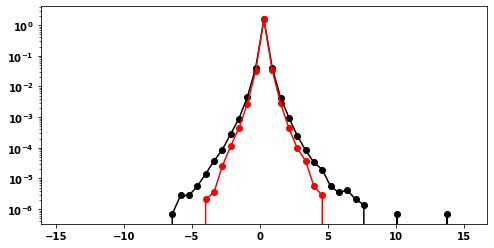

In [3]:
Jbaseline_weights_lst = extract_weights(Jbaseline, directed=True, nonzero=False)
Jpresz_weights_lst    = extract_weights(Jpresz, directed=True, nonzero=False)

plt.figure(figsize=(8,4))
plt.yscale('log')
Jbaseline_hist, Jbaseline_bins = np.histogram(Jbaseline_weights_lst, bins=np.linspace(-15,15,50), density=True)
plt.plot(Jbaseline_bins[1:], Jbaseline_hist, color='k')
plt.scatter(Jbaseline_bins[1:], Jbaseline_hist, color='k')

Jpresz_hist, Jpresz_bins = np.histogram(Jpresz_weights_lst, bins=np.linspace(-15,15,50), density=True)
plt.plot(Jpresz_bins[1:], Jpresz_hist, color='r')
plt.scatter(Jpresz_bins[1:], Jpresz_hist, color='r')
plt.show()

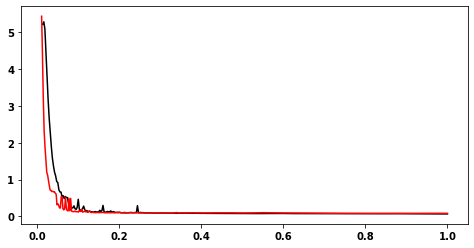

In [41]:
baseline_errors_fp = '/mnt/f/dhh-soltesz-lab/zfish-modeling-outputs/f2/baseline/v1/baseline-errors-3152020.npz'
presz_errors_fp = '/mnt/f/dhh-soltesz-lab/zfish-modeling-outputs/f2/presz/v1/presz-errors-3152020.npz'

f = np.load(baseline_errors_fp)
baseline_errors = f['errors']
baseline_nepochs = len(baseline_errors)
f.close()

f = np.load(presz_errors_fp)
presz_errors = f['errors']
presz_nepochs = len(presz_errors)
f.close()

plt.figure(figsize=(8,4))
plt.plot(np.linspace(0., 1., baseline_nepochs)[5:], baseline_errors[5:], color='k')
plt.plot(np.linspace(0.,1., presz_nepochs)[5:], presz_errors[5:], color='r')


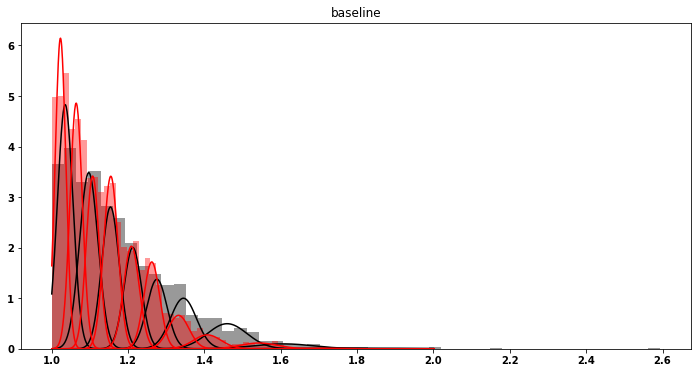

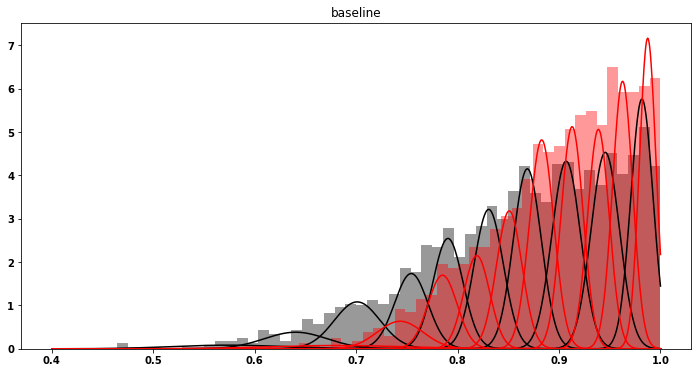

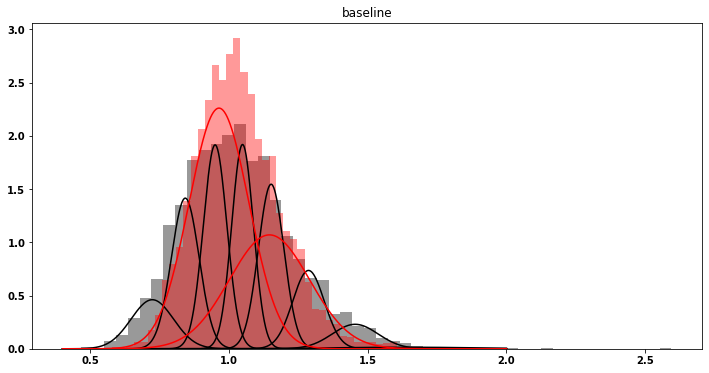

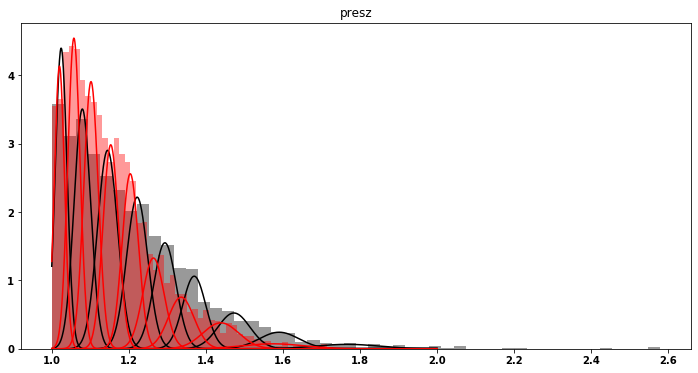

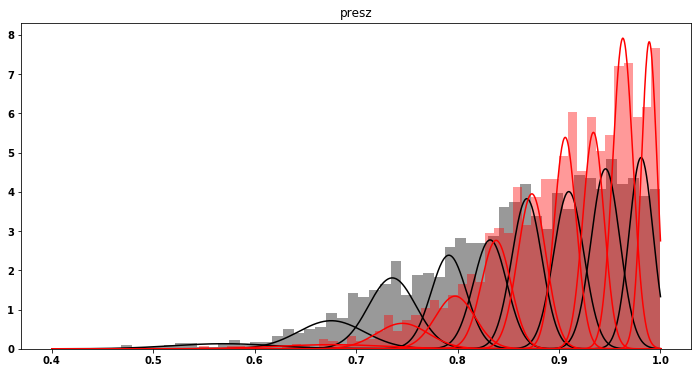

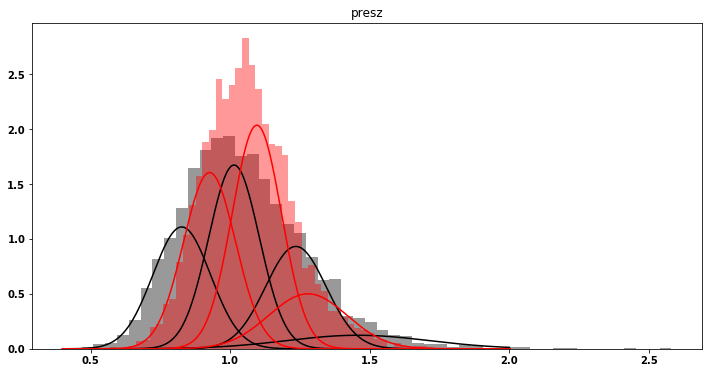

In [51]:
## ei ratios


def plot_ei(x,xx,xpdf,y,yy,ypdf, title, direction='exc'):
    if direction == 'exc':
        x = x[x>1]
        y = y[y>1]
    elif direction == 'inh':
        x = x[x<1]
        y = y[y<1]
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax.hist(x, alpha=0.4, rwidth=0.65, density=True, bins=50, color='k', histtype='stepfilled')
    ax.plot(xx, xpdf, color='k')
    
    ax.hist(y, alpha=0.4, rwidth=0.65, density=True, bins=50, color='r', histtype='stepfilled')
    ax.plot(yy, ypdf, color='r')
    ax.set_title(title)
    plt.show()
    
    
def get_pre_post_ei(J):
    pre_ei, post_ei = [], []
    for i in range(J.shape[0]):
        pre_ei.append(get_ei(J[:,i]))
        post_ei.append(get_ei(J[i,:]))      
    return np.asarray(pre_ei, dtype='float32'), np.asarray(post_ei, dtype='float32')
    
def plot_ei_group(J, state):
    pre_ei, post_ei = get_pre_post_ei(J)

    title = '%s' % state
    pre_ei_x, pre_ei_pdf_individual, pre_ei_model_labels   = gaussian_mixture_modeling(pre_ei[pre_ei>1], minn=1., maxx=2.0)
    post_ei_x, post_ei_pdf_individual, post_ei_model_labels = gaussian_mixture_modeling(post_ei[post_ei>1], minn=1., maxx=2.0)
    plot_ei(pre_ei, pre_ei_x, pre_ei_pdf_individual, post_ei, post_ei_x, post_ei_pdf_individual, title, direction='exc')

    title = '%s' % state
    pre_ei_x, pre_ei_pdf_individual, pre_ei_model_labels   = gaussian_mixture_modeling(pre_ei[pre_ei<1], minn=0.4, maxx=1.0)
    post_ei_x, post_ei_pdf_individual, post_ei_model_labels = gaussian_mixture_modeling(post_ei[post_ei<1], minn=0.4, maxx=1.0)
    plot_ei(pre_ei, pre_ei_x, pre_ei_pdf_individual, post_ei, post_ei_x, post_ei_pdf_individual, title, direction='inh')

    title = '%s' % state
    pre_ei_x, pre_ei_pdf_individual, pre_ei_model_labels   = gaussian_mixture_modeling(pre_ei, minn=0.4, maxx=2.0)
    post_ei_x, post_ei_pdf_individual, post_ei_model_labels = gaussian_mixture_modeling(post_ei, minn=0.4, maxx=2.0)
    plot_ei(pre_ei, pre_ei_x, pre_ei_pdf_individual, post_ei, post_ei_x, post_ei_pdf_individual, title, direction='null')

    
plot_ei_group(Jbaseline, 'baseline')
plot_ei_group(Jpresz, 'presz')

# 1, 2 baseline pre vs baseline post (E)
# 3, 4 presz pre vs presz post (E)
# 5, 6 baseline pre vs presz pre (E)
# 7, 8 baseline post vs presz post (E)

## post is red

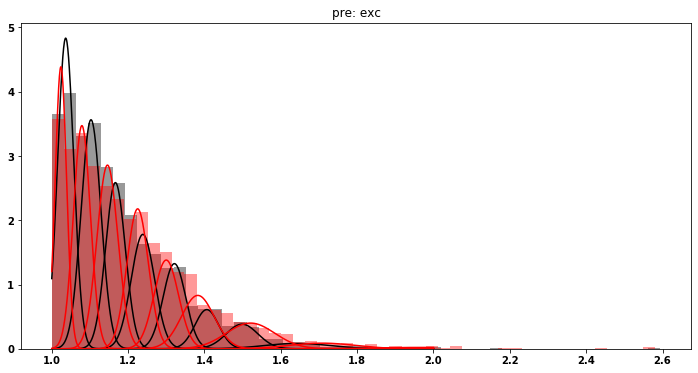

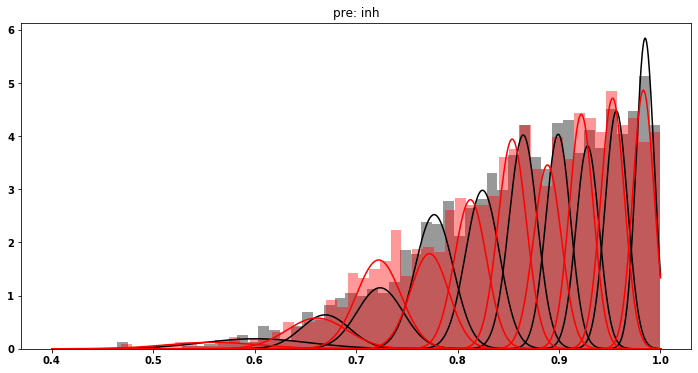

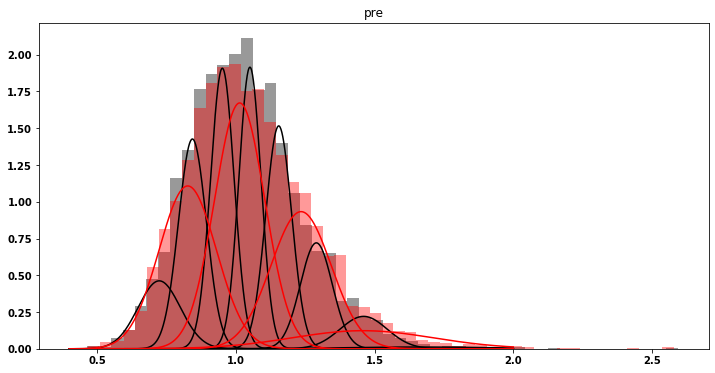

In [47]:
# pre

baseline_pre_ei, baseline_post_ei = get_pre_post_ei(Jbaseline)
presz_pre_ei, presz_post_ei       = get_pre_post_ei(Jpresz)

baseline_pre_ei_x, baseline_pre_ei_pdf_individual, baseline_pre_ei_model_labels = gaussian_mixture_modeling(baseline_pre_ei[baseline_pre_ei>1], minn=1.0, maxx=2.0)
presz_pre_ei_x, presz_pre_ei_pdf_individual, presz_pre_ei_model_labels          = gaussian_mixture_modeling(presz_pre_ei[presz_pre_ei>1], minn=1.0, maxx=2.0)

plot_ei(baseline_pre_ei, baseline_pre_ei_x, baseline_pre_ei_pdf_individual, 
        presz_pre_ei, presz_pre_ei_x, presz_pre_ei_pdf_individual, 'pre: exc', direction='exc')


baseline_pre_ei_x, baseline_pre_ei_pdf_individual, baseline_pre_ei_model_labels = gaussian_mixture_modeling(baseline_pre_ei[baseline_pre_ei<1], minn=0.4, maxx=1.0)
presz_pre_ei_x, presz_pre_ei_pdf_individual, presz_pre_ei_model_labels          = gaussian_mixture_modeling(presz_pre_ei[presz_pre_ei<1], minn=0.4, maxx=1.0)

plot_ei(baseline_pre_ei, baseline_pre_ei_x, baseline_pre_ei_pdf_individual, 
        presz_pre_ei, presz_pre_ei_x, presz_pre_ei_pdf_individual, 'pre: inh', direction='inh')

baseline_pre_ei_x, baseline_pre_ei_pdf_individual, baseline_pre_ei_model_labels = gaussian_mixture_modeling(baseline_pre_ei, minn=0.4, maxx=2.0)
presz_pre_ei_x, presz_pre_ei_pdf_individual, presz_pre_ei_model_labels          = gaussian_mixture_modeling(presz_pre_ei, minn=0.4, maxx=2.0)

plot_ei(baseline_pre_ei, baseline_pre_ei_x, baseline_pre_ei_pdf_individual, 
        presz_pre_ei, presz_pre_ei_x, presz_pre_ei_pdf_individual, 'pre', direction='null')


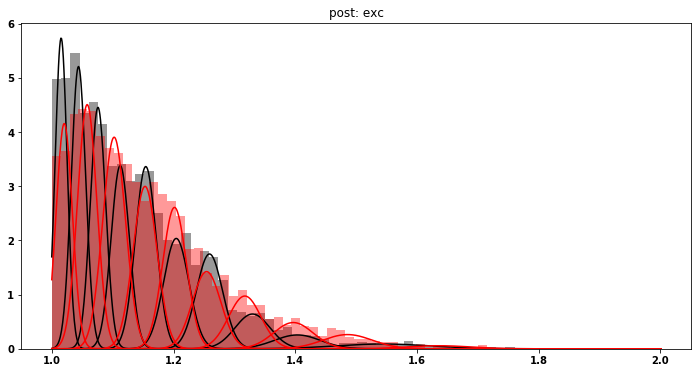

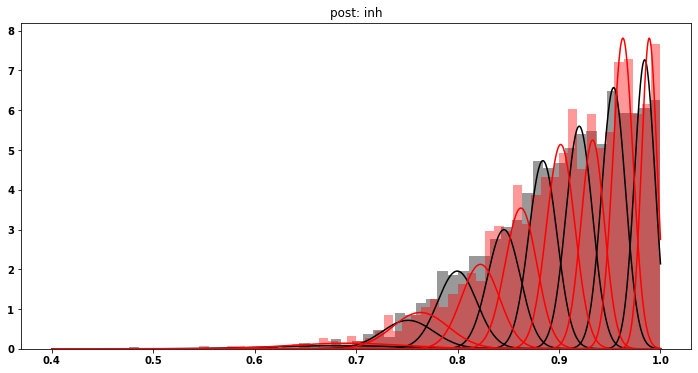

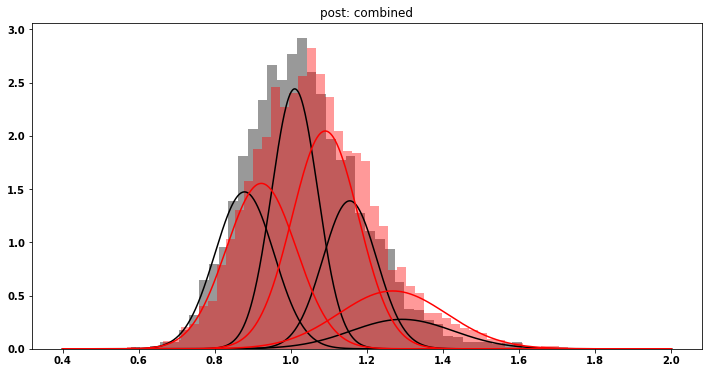

In [48]:
# post 

baseline_post_ei, baseline_pre_ei = get_pre_post_ei(Jbaseline)
presz_post_ei, presz_pre_ei       = get_pre_post_ei(Jpresz)

baseline_pre_ei_x, baseline_pre_ei_pdf_individual, baseline_pre_ei_model_labels = gaussian_mixture_modeling(baseline_pre_ei[baseline_pre_ei>1], minn=1.0, maxx=2.0)
presz_pre_ei_x, presz_pre_ei_pdf_individual, presz_pre_ei_model_labels          = gaussian_mixture_modeling(presz_pre_ei[presz_pre_ei>1], minn=1.0, maxx=2.0)

plot_ei(baseline_pre_ei, baseline_pre_ei_x, baseline_pre_ei_pdf_individual, 
        presz_pre_ei, presz_pre_ei_x, presz_pre_ei_pdf_individual, 'post: exc', direction='exc')


baseline_pre_ei_x, baseline_pre_ei_pdf_individual, baseline_pre_ei_model_labels = gaussian_mixture_modeling(baseline_pre_ei[baseline_pre_ei<1], minn=0.4, maxx=1.0)
presz_pre_ei_x, presz_pre_ei_pdf_individual, presz_pre_ei_model_labels          = gaussian_mixture_modeling(presz_pre_ei[presz_pre_ei<1], minn=0.4, maxx=1.0)

plot_ei(baseline_pre_ei, baseline_pre_ei_x, baseline_pre_ei_pdf_individual, 
        presz_pre_ei, presz_pre_ei_x, presz_pre_ei_pdf_individual, 'post: inh', direction='inh')

baseline_pre_ei_x, baseline_pre_ei_pdf_individual, baseline_pre_ei_model_labels = gaussian_mixture_modeling(baseline_pre_ei, minn=0.4, maxx=2.0)
presz_pre_ei_x, presz_pre_ei_pdf_individual, presz_pre_ei_model_labels          = gaussian_mixture_modeling(presz_pre_ei, minn=0.4, maxx=2.0)

plot_ei(baseline_pre_ei, baseline_pre_ei_x, baseline_pre_ei_pdf_individual, 
        presz_pre_ei, presz_pre_ei_x, presz_pre_ei_pdf_individual, 'post: combined', direction='null')
